# Cost-Sensitive IT Customer Churn Detection (No SMOTE, FN Optimized)

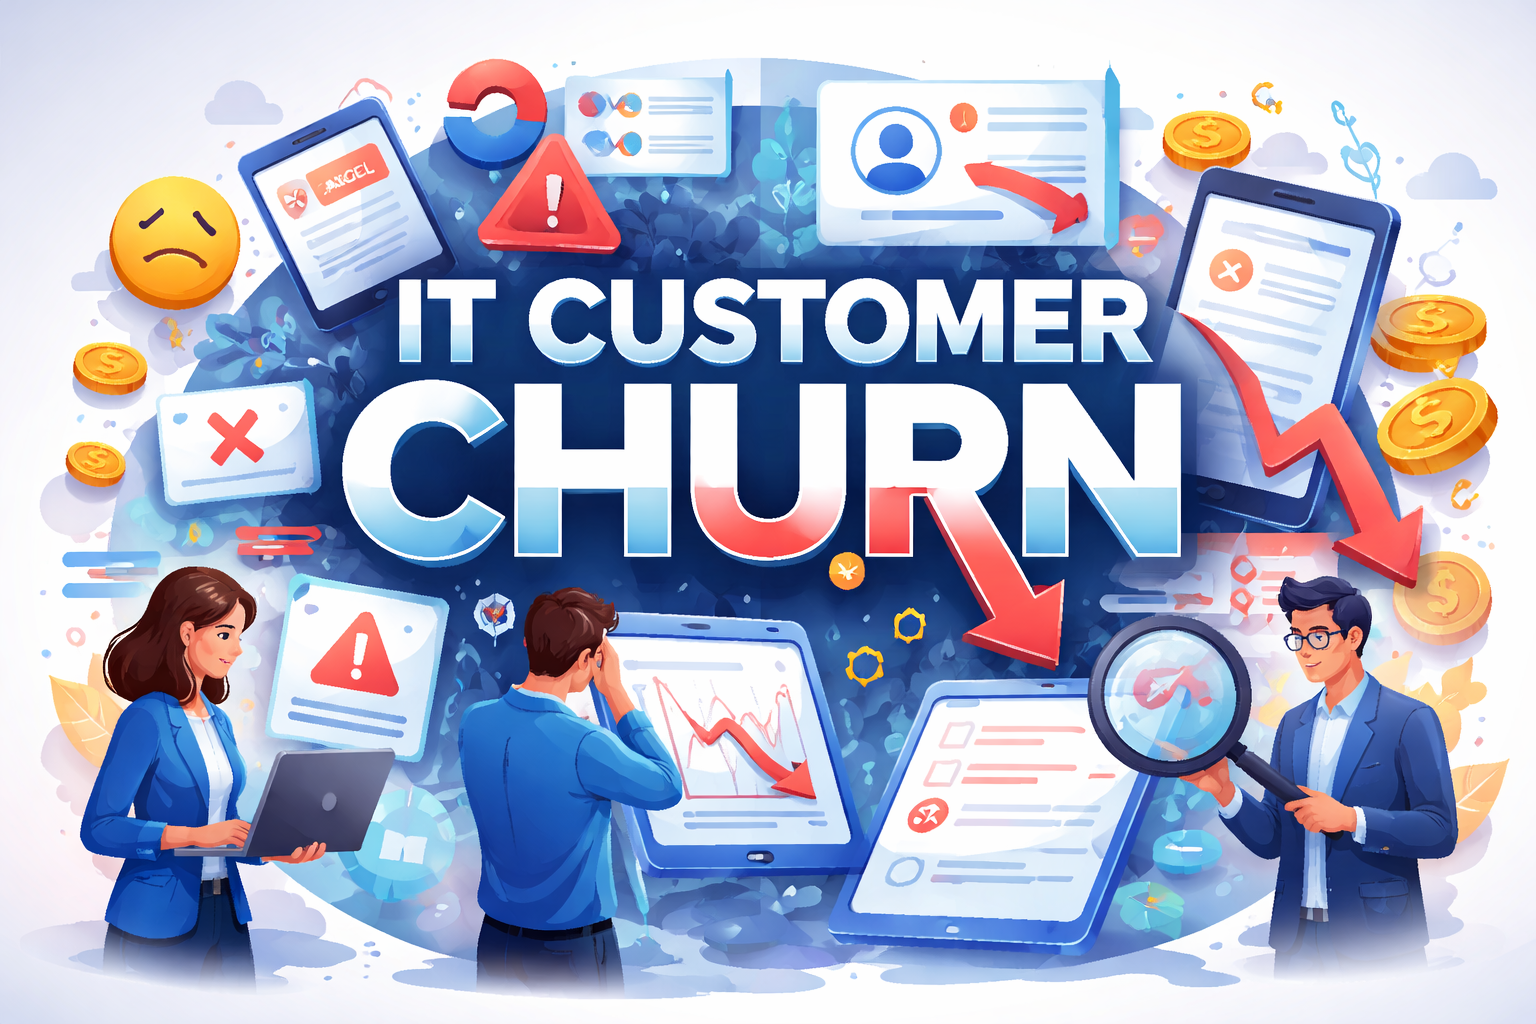

## Overview

Customer churn prediction is a critical task in IT services due to its direct impact on revenue and customer retention strategies.  
This dataset is highly imbalanced, making churn detection particularly challenging.  
The focus of this project is to reduce **False Negatives** using a cost-sensitive modeling approach.

## Key Idea

- **No SMOTE / No data resampling**  
  - Preserves original data distribution and avoids synthetic noise  

- **Class weighting during model training**  
  - Encourages model to prioritize detecting churned customers

- **Decision threshold tuning**  
  - Adjusts the classification threshold to further reduce **False Negatives** 

- **Primary goal:**  
  - Minimize **False Negatives (FN)**  
  - Correctly identify potential churners for business retention

## Why Not SMOTE?

SMOTE was intentionally avoided to preserve the original data distribution and ensure production reliability.  
Synthetic samples may introduce noise and lead to overly optimistic results.

Since the primary objective is minimizing **False Negatives**, a **cost-sensitive approach** using class weighting and decision threshold tuning was applied instead of data resampling.


> In churn prediction, missing a churned customer (False Negative) is often significantly more costly than incorrectly flagging a loyal one.


## 1️⃣ Loading libraries and data

In [100]:
import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt 
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, precision_recall_curve)

In [101]:
df = pd.read_csv('/kaggle/input/it-customer-churn/IT_customer_churn.csv')

## 2️⃣ Data Overview

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [103]:
df.sample(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
466,Male,1,Yes,No,64,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Two year,No,Electronic check,102.1,6538.45,No
2278,Female,1,No,No,7,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,48.2,340.35,No
7021,Male,0,No,No,12,Yes,No,DSL,No,No,No,Yes,Yes,No,One year,Yes,Electronic check,59.8,727.8,Yes



- **Dataset:** Telco Customer Churn  
- **Target variable:** `Churn` (Yes/No)  
- Clear **class imbalance** → motivates cost-sensitive modeling
> The emphasis is on **business impact**, not just overall accuracy.

In [104]:
def print_value(DF):
    for column in DF.columns:
        if DF[column].dtype == object:
            print(f"{column} : {DF[column].unique()}")

In [105]:
print_value(df)

gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges : ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn : ['No' 'Yes']


## 3️⃣ Missing Value Analysis

In [106]:
df.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [107]:
df["TotalCharges"] = pd.to_numeric(df.TotalCharges , errors='coerce')
df[np.isnan(df['TotalCharges'])]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [108]:
df.drop(labels=df[df['tenure'] == 0].index, axis=0, inplace=True)
df[df['tenure'] == 0].index

Index([], dtype='int64')

> **Note:** Rows with `tenure = 0` are removed to avoid noisy and non-informative samples.

<Axes: >

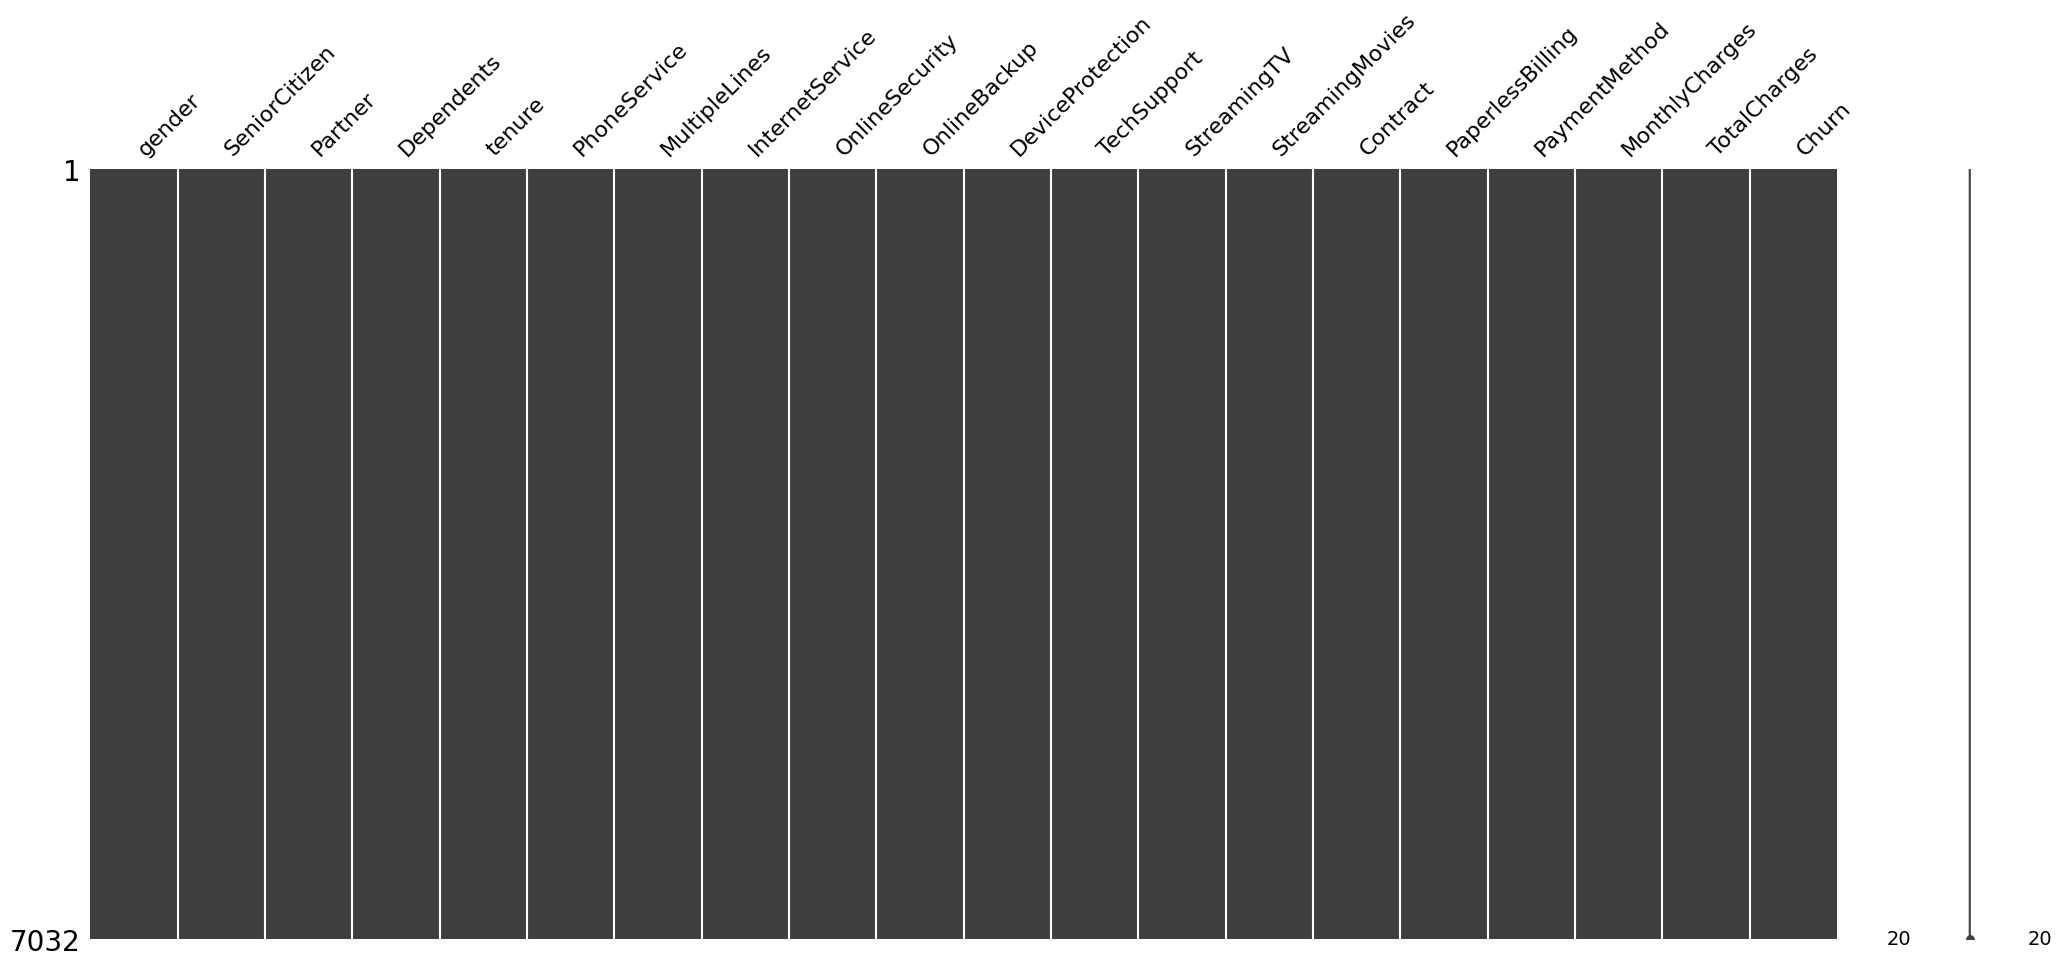

In [109]:
msno.matrix(df)

## 4️⃣ Exploratory Data Analysis (EDA)
> In this EDA, we explore the **imbalanced** `Churn` distribution and examine feature **correlations** with a heatmap.

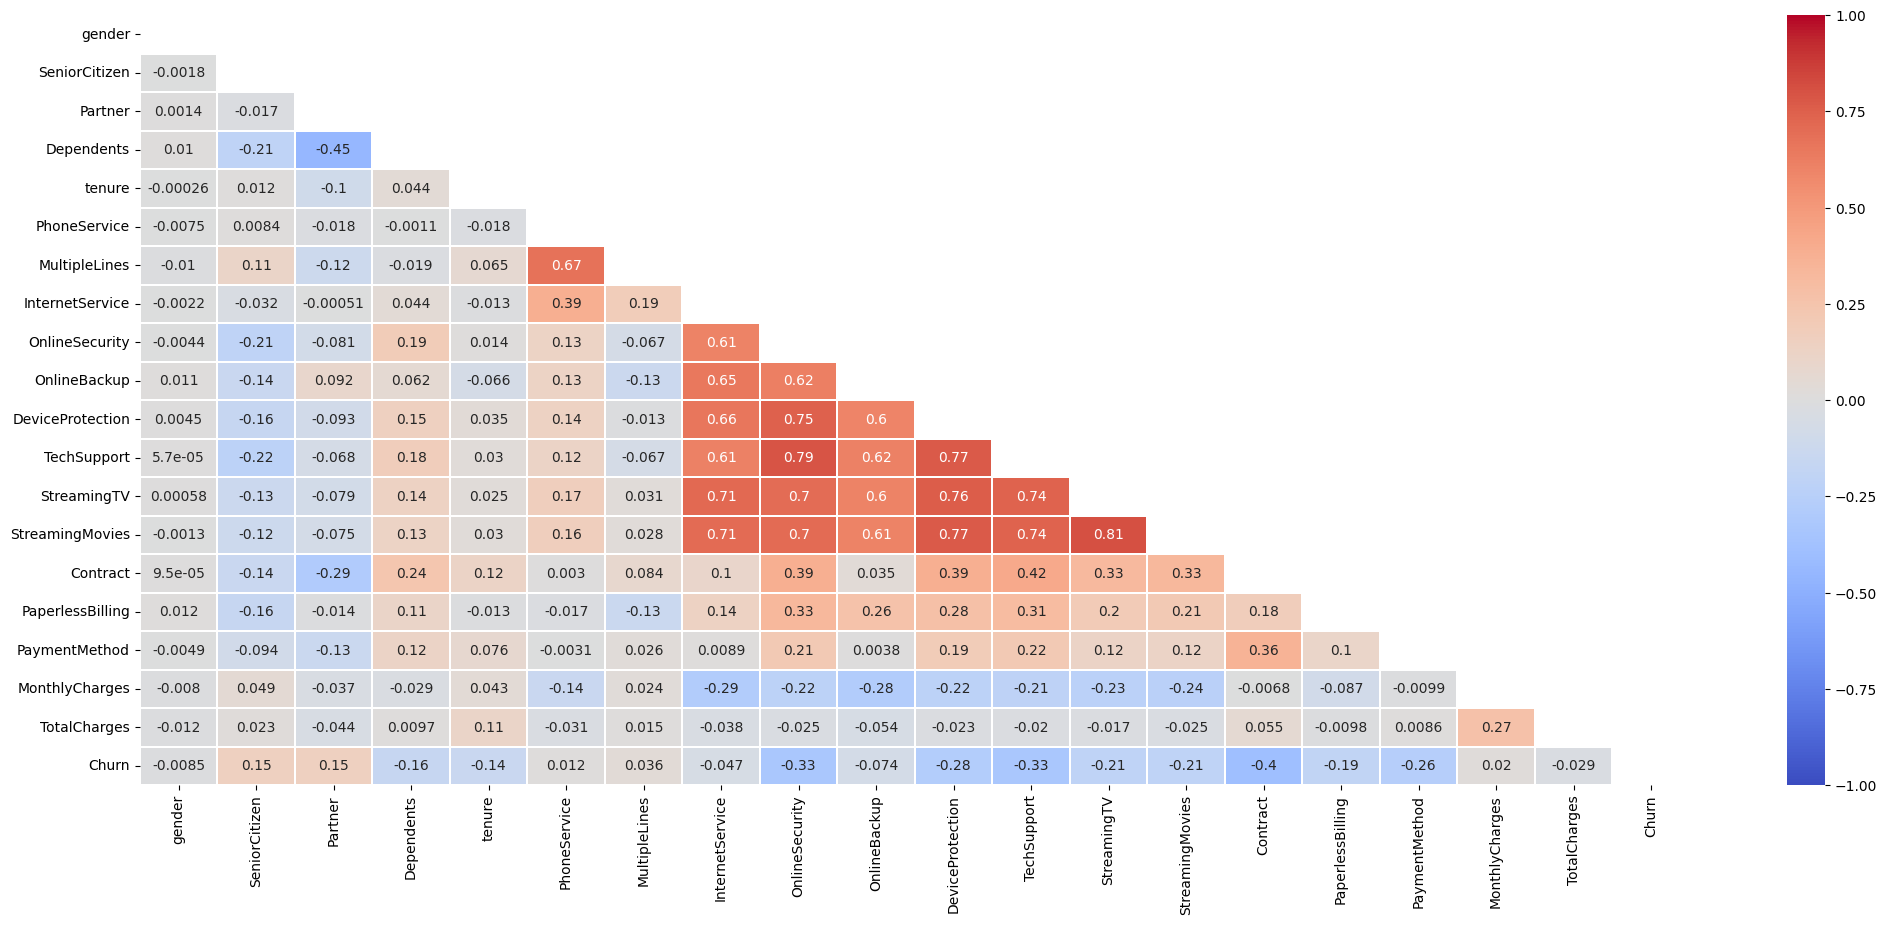

In [110]:
plt.figure(figsize=(25, 10))

corr = df.apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

In [111]:
df1.corr()['Churn'].sort_values(ascending = False)

Churn                                    1.000000
InternetService_Fiber optic              0.307463
PaymentMethod_Electronic check           0.301455
MonthlyCharges                           0.192858
PaperlessBilling                         0.191454
SeniorCitizen                            0.150541
StreamingTV_Yes                          0.063254
StreamingMovies_Yes                      0.060860
MultipleLines_Yes                        0.040033
PhoneService                             0.011691
gender                                  -0.008545
MultipleLines_No phone service          -0.011691
DeviceProtection_Yes                    -0.066193
OnlineBackup_Yes                        -0.082307
PaymentMethod_Mailed check              -0.090773
PaymentMethod_Credit card (automatic)   -0.134687
Partner                                 -0.149982
Dependents                              -0.163128
TechSupport_Yes                         -0.164716
OnlineSecurity_Yes                      -0.171270


/tmp/ipykernel_55/1531909498.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Churn', y='tenure', data=df ,palette="pastel")
/tmp/ipykernel_55/1531909498.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df['Churn'] ,  data=df,palette="pastel")


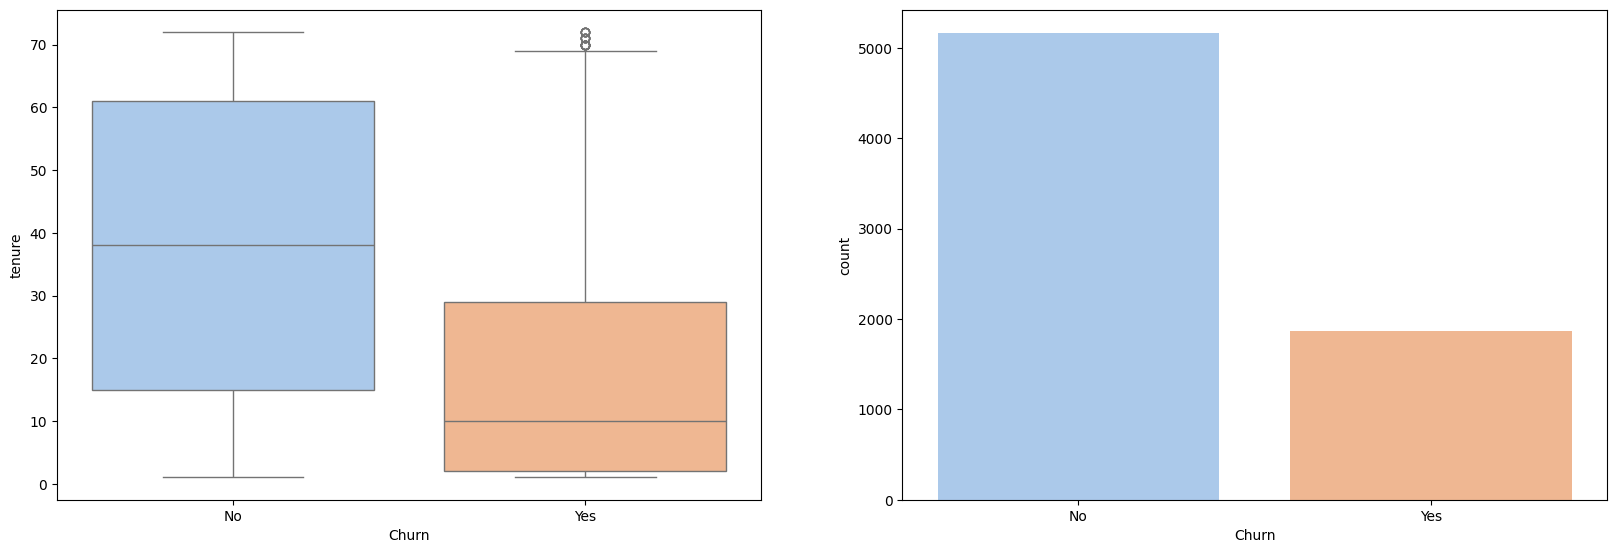

In [112]:
fig = plt.figure(figsize=(20,14))

plt.subplot(2,2,1)
ax = sns.boxplot(x='Churn', y='tenure', data=df ,palette="pastel")
plt.subplot(2,2,2)
ax = sns.countplot(x=df['Churn'] ,  data=df,palette="pastel")

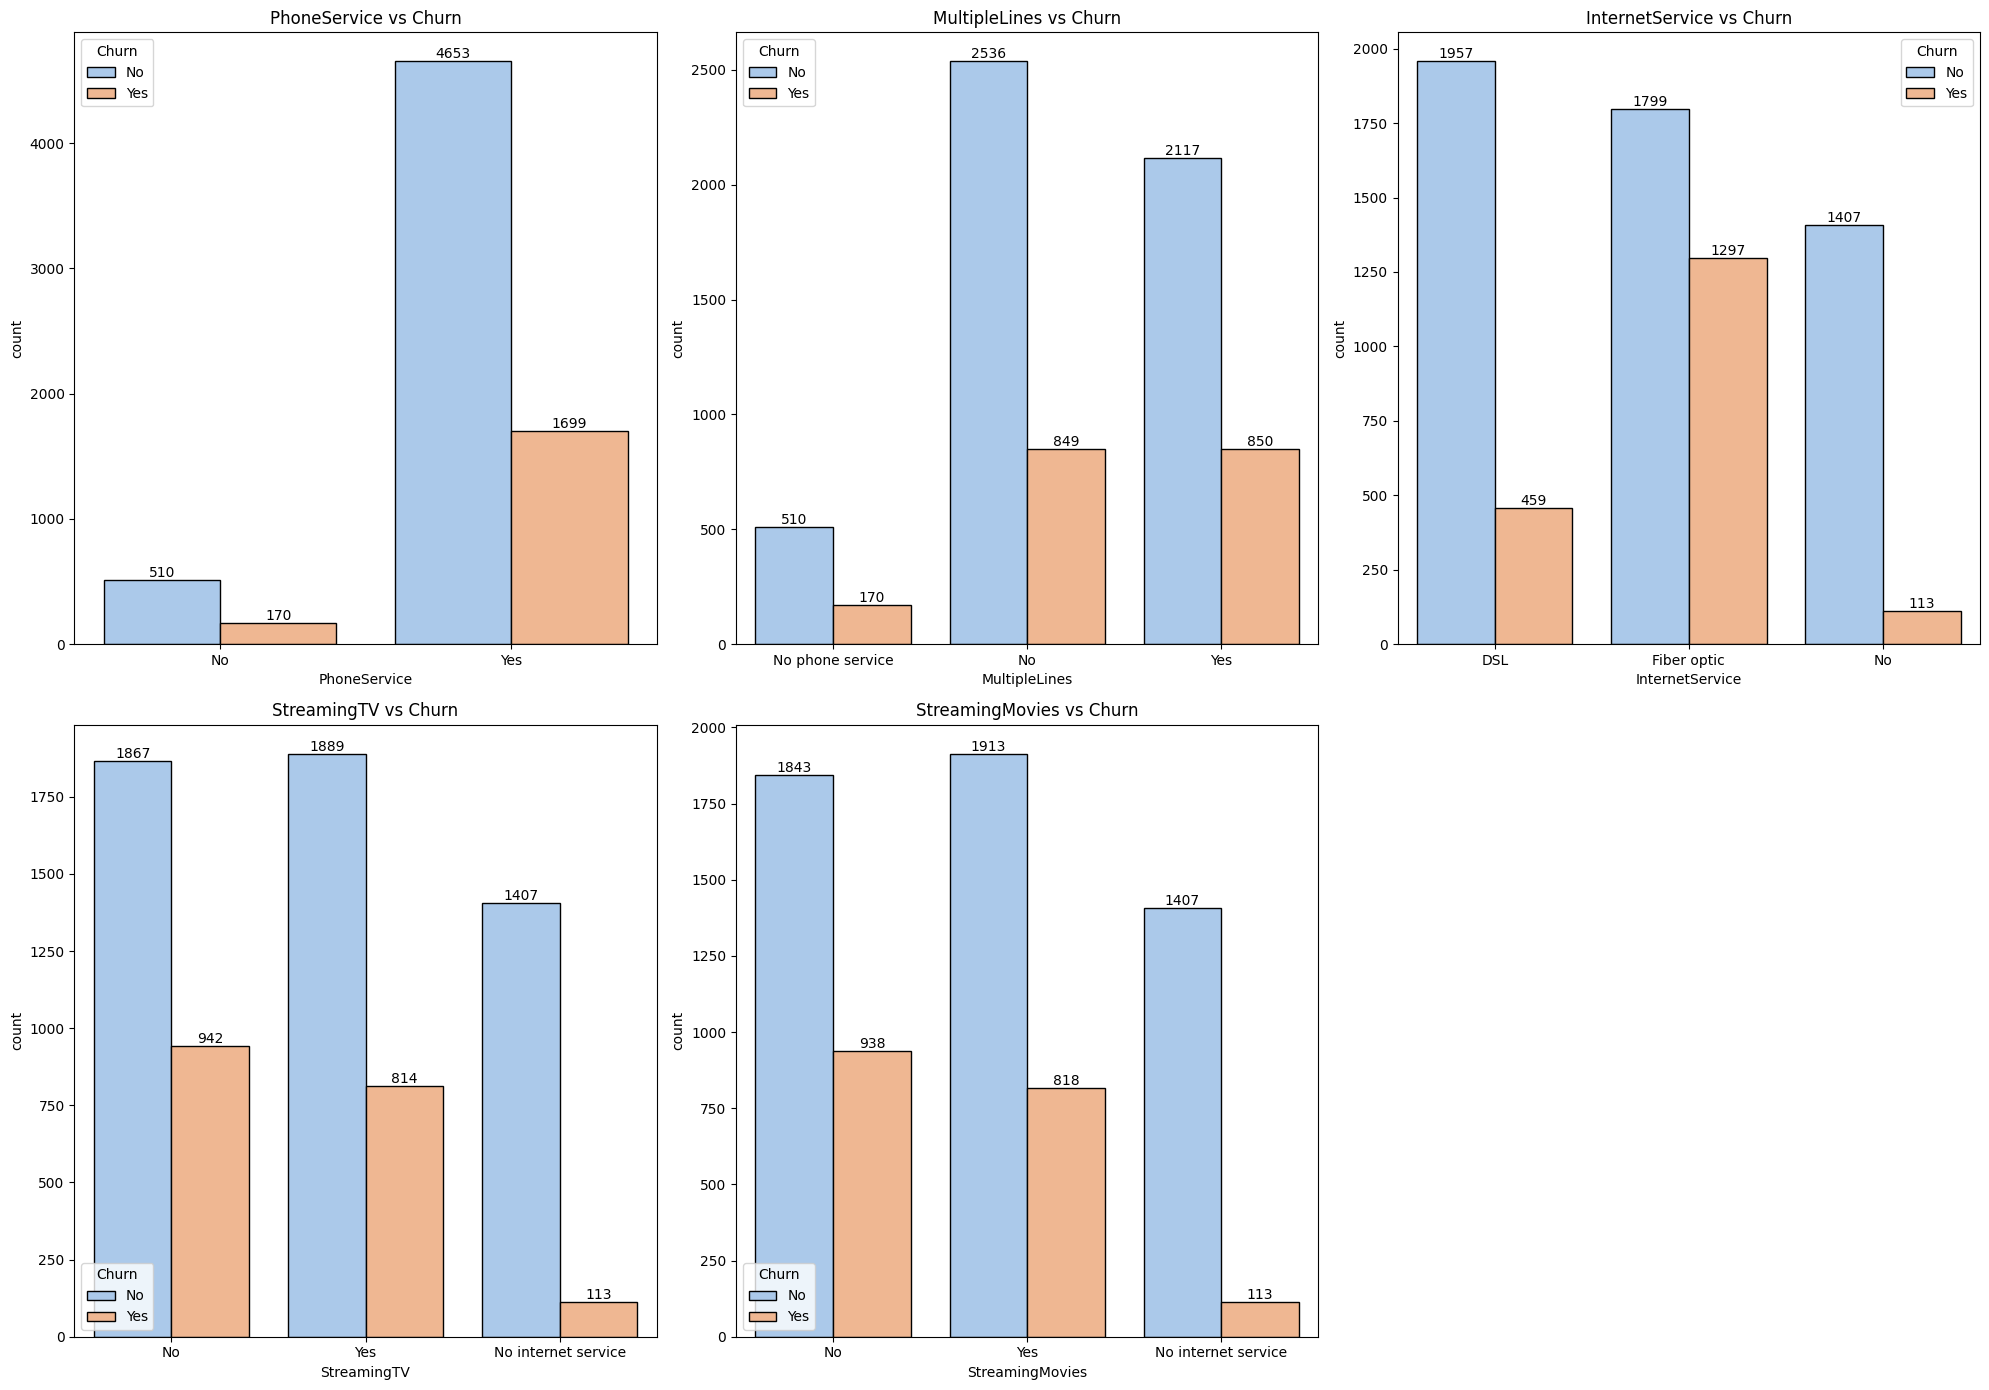

In [113]:
list2 = ['PhoneService', 'MultipleLines', 'InternetService', 'StreamingTV', 'StreamingMovies']
fig = plt.figure(figsize=(20,14))

plt.subplot(2,3,1)
ax = sns.countplot(data = df, x=list2[0], hue = "Churn",  edgecolor = 'black',palette="pastel")
ax.legend(loc='upper left', title='Churn')
for i in ax.containers:
    ax.bar_label(i,)
title = list2[0] + ' vs Churn'
plt.title(title);

plt.subplot(2,3,2)
ax = sns.countplot(data = df, x=list2[1], hue = "Churn",  edgecolor = 'black' ,palette="pastel")
ax.legend(loc='upper left', title='Churn')
for i in ax.containers:
    ax.bar_label(i,)
title = list2[1] + ' vs Churn'
plt.title(title);

plt.subplot(2,3,3)
ax = sns.countplot(data = df, x=list2[2], hue = "Churn",  edgecolor = 'black' ,palette="pastel")
ax.legend(loc='upper right', title='Churn')
for i in ax.containers:
    ax.bar_label(i,)
title = list2[2] + ' vs Churn'
plt.title(title)

plt.subplot(2,3,4)
ax = sns.countplot(data = df, x=list2[3], hue = "Churn",  edgecolor = 'black', palette="pastel")
ax.legend(loc='lower left', title='Churn')
for i in ax.containers:
    ax.bar_label(i,)
title = list2[3] + ' vs Churn'
plt.title(title);

plt.subplot(2,3,5)
ax = sns.countplot(data = df, x=list2[4], hue = "Churn", edgecolor = 'black', palette="pastel")
ax.legend(loc='lower left', title='Churn')
for i in ax.containers:
    ax.bar_label(i,)
title = list2[4] + ' vs Churn'
plt.title(title)

plt.tight_layout()
plt.show()

## 5️⃣ Data Preprocessing
> Categorical features are one-hot encoded and numerical features are scaled to prepare the dataset for model training.

In [114]:
df1 = df.copy(0)

In [115]:
columns_onehot = ["MultipleLines" ,"InternetService","OnlineSecurity" ,"OnlineBackup" ,"DeviceProtection" , "TechSupport","StreamingTV" , "StreamingMovies" , "Contract" , "PaymentMethod"  ]
columns_encode = ["Partner","Dependents" ,"PhoneService" ,"PaperlessBilling" , "Churn"]

In [116]:
df1['gender'] = df1['gender'].map({'Male': 1, 'Female': 0})
for col in columns_encode:
    df1[col] = df1[col].map({"Yes" : 1 , "No" : 0})

In [117]:
df1 = pd.get_dummies(df1 , columns=columns_onehot , drop_first=True , dtype=int)

In [118]:
X = df1.drop('Churn', axis=1)
y = df1['Churn']

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [120]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 6️⃣ Model Training

- **Hyperparameter tuning:** Key parameters such as number of estimators, max depth, learning rate, and min samples per leaf were optimized for better performance.
- **Class weighting / Cost-sensitive approach:** Applied to address the class imbalance and prioritize detecting churned customers.
- **Focus:** Minimize **False Negatives (FN)** while preserving overall model stability.

In [121]:
xgboost = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.2,
    scale_pos_weight=5000/1800,  
    eval_metric='aucpr',
    random_state=42,
    n_jobs=-1
)
xgboost.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=-1, num_parallel_tree=None, ...)

In [122]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=8,
    min_samples_leaf=3,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=3, min_samples_split=8,
                       n_estimators=300, n_jobs=-1, random_state=42)

In [123]:

log_model_adv = LogisticRegression(
    class_weight={0:1, 1:3},
    max_iter=1000
)
log_model_adv.fit(X_train_scaled, y_train)

LogisticRegression(class_weight={0: 1, 1: 3}, max_iter=1000)

In [124]:
catboost_5 = CatBoostClassifier(verbose=False,random_state=0,scale_pos_weight=5)


catboost_5.fit(X_train_scaled, y_train, eval_set=(X_test_scaled, y_test))

> **Both models are trained independently and evaluated under the same threshold tuning strategy to ensure a fair comparison focused on False Negatives.**

## 7️⃣ Model Evaluation and Decision Threshold Tuning

> **Note:**  
> The confusion matrices are shown after adjusting the decision **threshold** to highlight the impact on **False Negatives (FN)** and overall churn detection performance.

###  LogisticRegression

In [125]:
log_prob = log_model_adv.predict_proba(X_test_scaled)[:,1]
threshold = 0.4
log_pred = (log_prob >= threshold).astype(int)
print("Accuracy:", accuracy_score(y_test, log_pred))
print(confusion_matrix(y_test, log_pred))
print(classification_report(y_test, log_pred))

Accuracy: 0.6730632551528074
[[618 415]
 [ 45 329]]
              precision    recall  f1-score   support

           0       0.93      0.60      0.73      1033
           1       0.44      0.88      0.59       374

    accuracy                           0.67      1407
   macro avg       0.69      0.74      0.66      1407
weighted avg       0.80      0.67      0.69      1407



###  catboost

In [126]:
catboost_5_prob = catboost_5.predict_proba(X_test_scaled)[:,1]
threshold = 0.4
catboost_5_pred = (catboost_5_prob >= threshold).astype(int)
print("Accuracy:", accuracy_score(y_test, catboost_5_pred))
print(confusion_matrix(y_test, catboost_5_pred))
print(classification_report(y_test, catboost_5_pred))

Accuracy: 0.6247334754797441
[[530 503]
 [ 25 349]]
              precision    recall  f1-score   support

           0       0.95      0.51      0.67      1033
           1       0.41      0.93      0.57       374

    accuracy                           0.62      1407
   macro avg       0.68      0.72      0.62      1407
weighted avg       0.81      0.62      0.64      1407



### RandomForestClassifier

In [127]:
model_rf = rf.predict_proba(X_test_scaled)[:,1]
threshold_rf = 0.4
rf_pred = (model_rf >= threshold_rf).astype(int)
print("Accuracy:", accuracy_score(y_test, rf_pred))
print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

Accuracy: 0.738450604122246
[[738 295]
 [ 73 301]]
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1033
           1       0.51      0.80      0.62       374

    accuracy                           0.74      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.80      0.74      0.75      1407



###  xgboost

In [128]:
model_xgb = xgboost.predict_proba(X_test_scaled)[:,1]
threshold_xgb = 0.4
xgb_pred = (model_xgb >= threshold_xgb).astype(int)

print("Accuracy:", accuracy_score(y_test, xgb_pred))
print(confusion_matrix(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

Accuracy: 0.7085998578535891
[[689 344]
 [ 66 308]]
              precision    recall  f1-score   support

           0       0.91      0.67      0.77      1033
           1       0.47      0.82      0.60       374

    accuracy                           0.71      1407
   macro avg       0.69      0.75      0.69      1407
weighted avg       0.80      0.71      0.73      1407



> **Note:**  
> Adjusting the decision threshold may slightly reduce overall accuracy, but it significantly improves detection of **False Negatives (FN)**, which is critical for identifying potential churners.

## 8️⃣ Confusion Matrix Analysis 

Summarize key insights and highlight the impact of class weighting and threshold tuning on churn prediction.

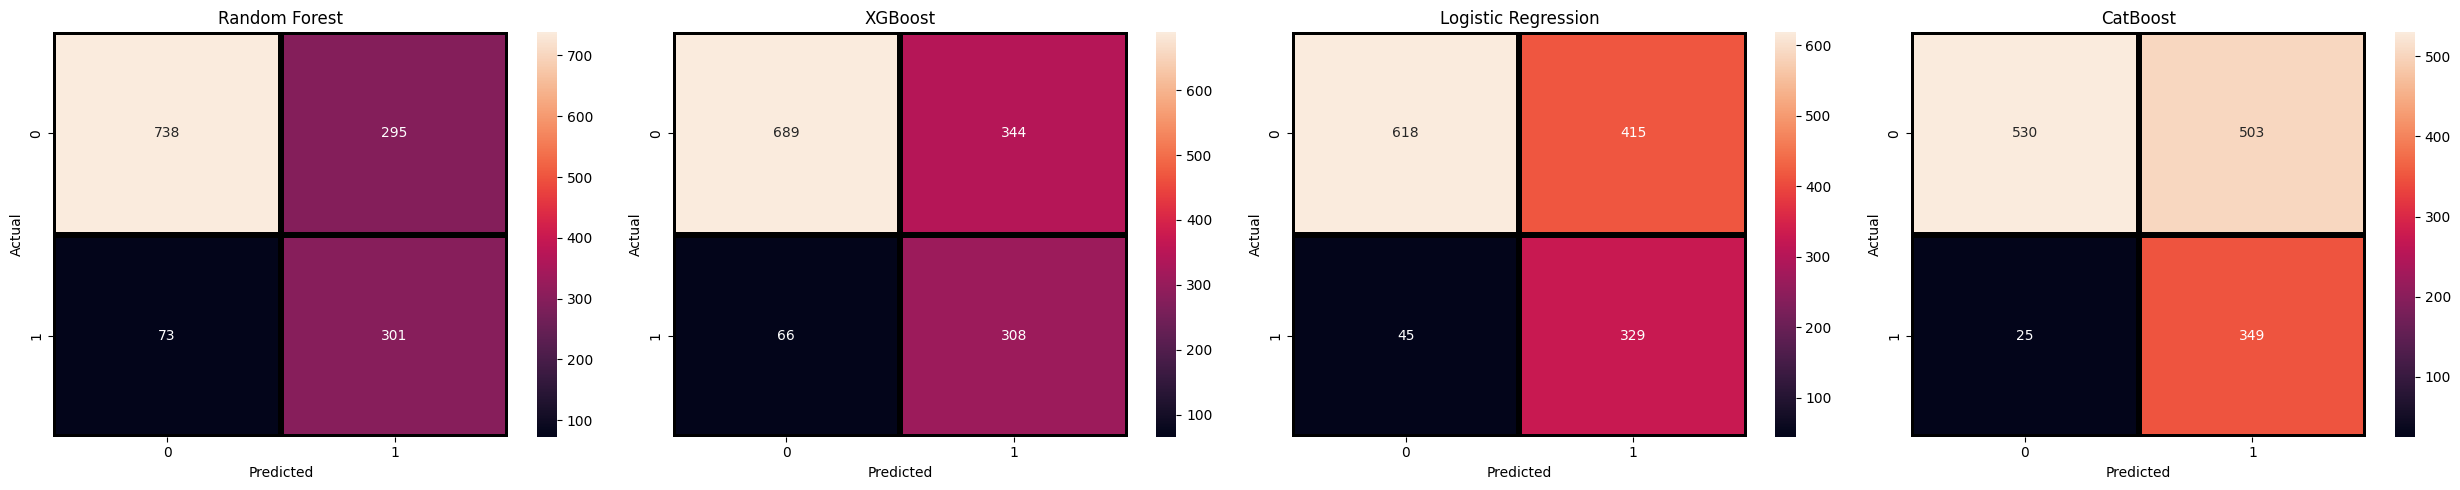

In [129]:
preds = [rf_pred,xgb_pred, log_pred, catboost_5_pred]
names = [ 'Random Forest','XGBoost', 'Logistic Regression', 'CatBoost']

fig, axes = plt.subplots(1, 4, figsize=(25,5))  
for ax, pred, name in zip(axes, preds, names):
    sns.heatmap(confusion_matrix(y_test, pred),
                annot=True,
                fmt="d",
                linecolor="k",
                linewidths=3,
                ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

<Axes: >

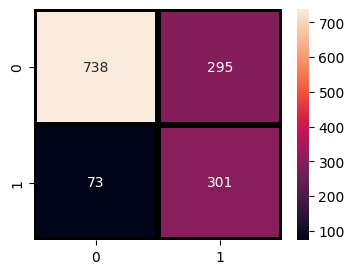

In [130]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, rf_pred),
                annot=True,fmt = "d",linecolor="k",linewidths=3)

<Axes: >

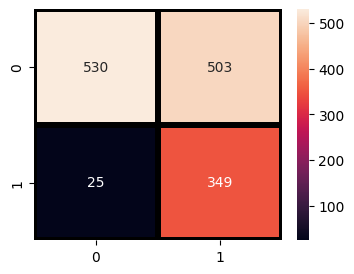

In [131]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, catboost_5_pred),
                annot=True,fmt = "d",linecolor="k",linewidths=3)

>   - Achieves the **lowest False Negatives (FN)**, prioritizing churn detection.

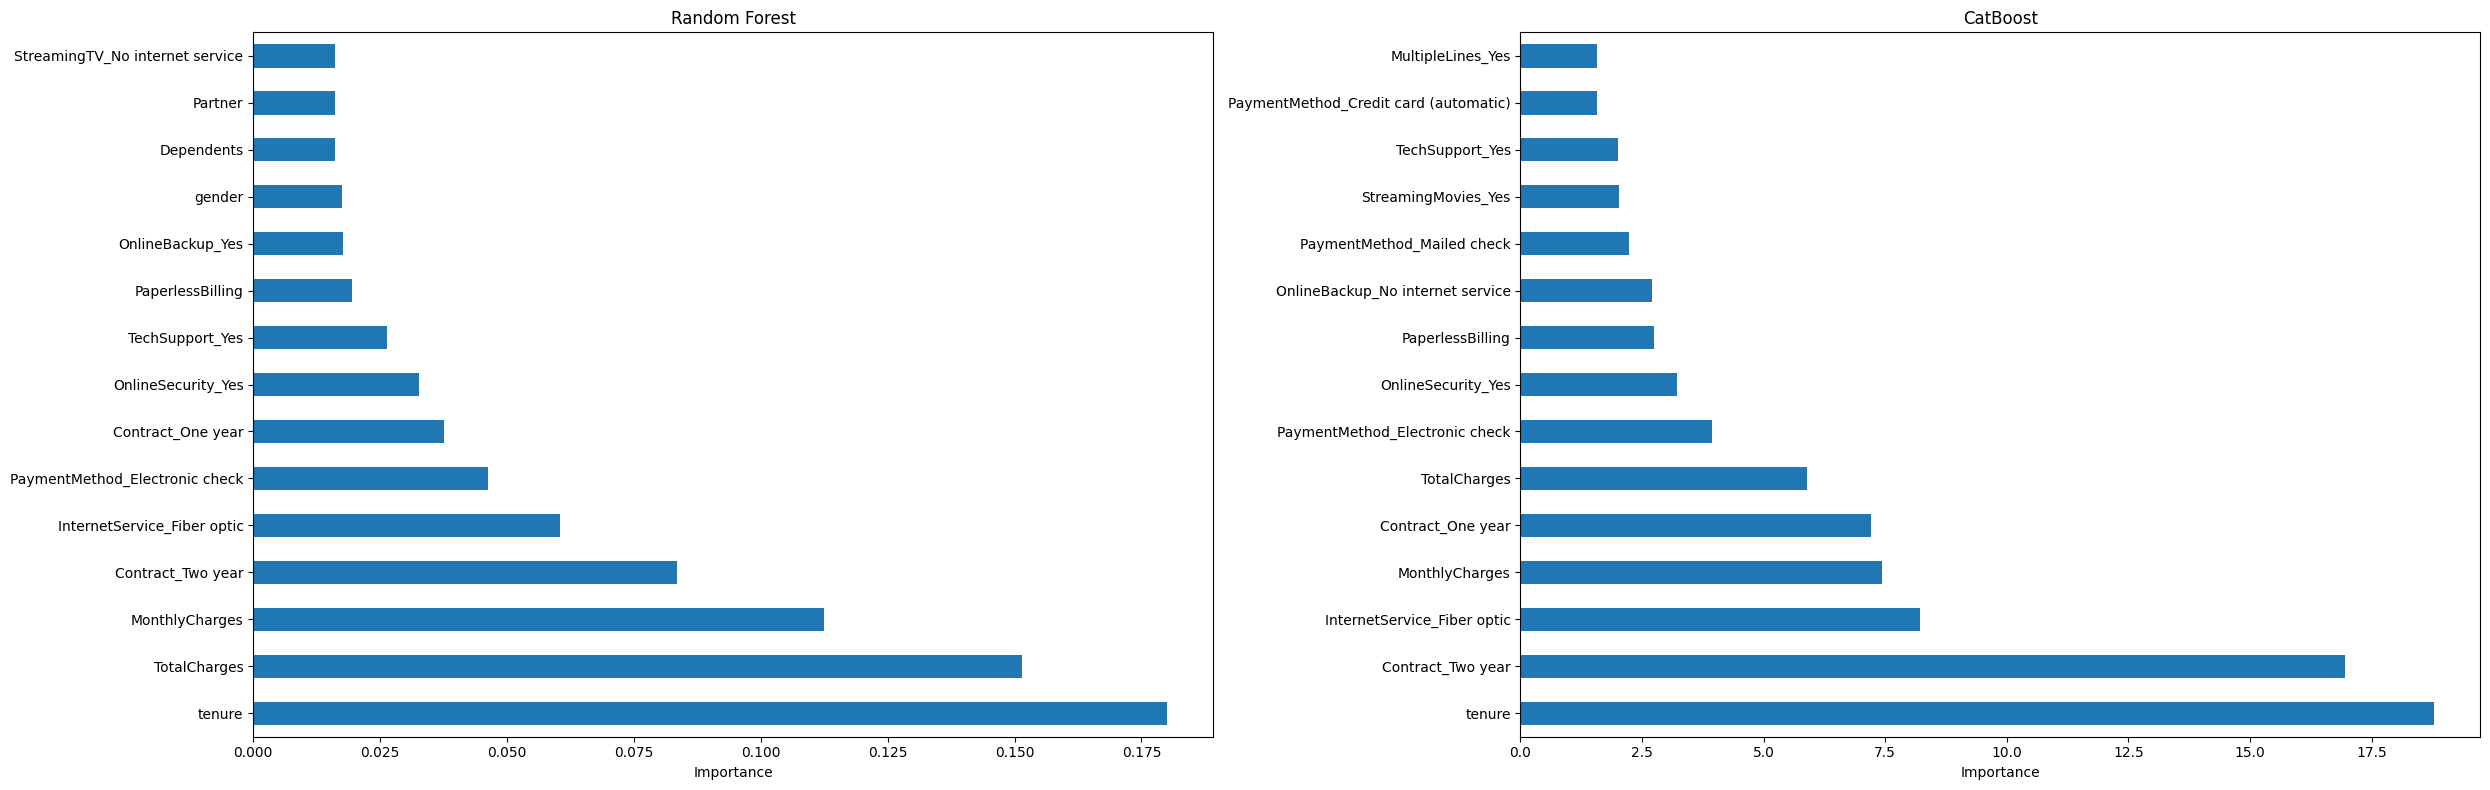

In [132]:
def plot_feature_importance(model, X, model_name, ax, top_n=15):
    if not hasattr(model, "feature_importances_"):
        print(f"{model_name} feature importance ندارد.")
        return
    
    importances = model.feature_importances_
    feature_names = X.columns
    feat_importances = pd.Series(importances, index=feature_names)
    

    feat_importances.nlargest(top_n).plot(kind='barh', ax=ax)
    ax.set_title(f"{model_name}")
    ax.set_xlabel("Importance")
    ax.set_ylabel("")


preds = [ rf, catboost_5]
names = [ 'Random Forest' , 'CatBoost']


fig, axes = plt.subplots(1, len(preds), figsize=(25, 8), sharey=False)

for ax, model, name in zip(axes, preds, names):
    plot_feature_importance(model, X_train, name, ax)

plt.tight_layout()
plt.show()

> **Top features** impacting churn prediction are shown for each trained model.

## 9️⃣ Model Comparison and Conclusion

- **Random Forest:**  
  - Highest overall accuracy among the trained models.  
  - However, it also produces the **highest False Negatives (FN)**.  
  - Suitable in scenarios where **missing churned customers has low business impact**, and overall predictive performance is more important than catching every churner.

- **CatBoost:**  
  - Slightly lower overall accuracy.  
  - Achieves the **lowest False Negatives (FN)**, prioritizing churn detection.  
  - Ideal for business-critical situations where **losing a customer is costly**, even at the expense of more False Positives (FP), as catching churners is the main goal.

> **Key insight:** Choosing a model depends on business priorities:  
> - If overall accuracy is prioritized → **Random Forest**.  
> - If minimizing missed churners is

## 🔟 Thank You! 🙏


**Thank you for taking the time to view my notebook.  Your comments and feedback are greatly appreciated and will help me improve further!**